In [16]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU (v6.7 - Tăng cường độ bền)
# ==============================================================================
import os
import json
import asyncio
import operator
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

# --- KHỞI TẠO LLM ---
try:
    # === NÂNG CẤP V6.7: THÊM CƠ CHẾ TỰ ĐỘNG THỬ LẠI ===
    # Thêm max_retries=2 để tự động thử lại 2 lần nếu gặp lỗi server (như lỗi 503)
    llm = ChatGroq(
        temperature=0.1, model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"), max_tokens=4096,
        max_retries=2
    )
    print("✅ LLM (Groq) v6.7 đã được khởi tạo thành công với cơ chế tự động thử lại.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

# --- TẢI KHO TRI THỨC ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
vector_store = None
if os.path.exists(VECTOR_STORE_PATH):
    try:
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vector_store = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("✅ Kho tri thức RAG đã được tải thành công.")
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")

✅ LLM (Groq) v6.7 đã được khởi tạo thành công với cơ chế tự động thử lại.
✅ Kho tri thức RAG đã được tải thành công.


In [17]:
# ==============================================================================
# CELL 2 (Hoàn chỉnh v6.1): SỬA LỖI STATE VÀ THÊM NODE KHỞI TẠO
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (Giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (Giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === SỬA LỖI: ĐỊNH NGHĨA STATE ĐƠN GIẢN HƠN ===
class TeacherStateV4(TypedDict):
    # original_request giờ là một trường bình thường
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    
    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    final_lesson_plan: Optional[str]
    next_agent: str

print("✅ 'TeacherStateV4' (đã sửa lỗi) đã được định nghĩa.")

# === GIẢI PHÁP: TẠO NODE KHỞI TẠO ===
def initialize_state_node(state: TeacherStateV4) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ 'TeacherStateV4' (đã sửa lỗi) đã được định nghĩa.
✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


In [18]:
# ==============================================================================
# CELL 3 (Phiên bản 6.9 - Kỷ luật Thời gian & Critic Nâng cao)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional, Union

# === CÁC HÀM TIỆN ÍCH VÀ PYDANTIC MODELS (KHÔNG ĐỔI) ===
def format_solution_guide(guide: Any) -> str:
    """Formats the solution_guide from various LLM outputs into a single string."""
    if not guide:
        return "Chưa có hướng dẫn."
    if isinstance(guide, str):
        return guide
    if isinstance(guide, list):
        # Nối các mục trong danh sách lại, mỗi mục một dòng
        return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict):
        # Chuyển dictionary thành các dòng key: value
        return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    # Fallback cho mọi trường hợp khác
    return str(guide)

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập này thật hấp dẫn và rõ ràng.")
    description: str = Field(description="Mô tả chi tiết các bước giáo viên và học sinh cần thực hiện trong hoạt động.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT) để hoàn thành hoạt động.")
    activity_type: str = Field(description="Phân loại hoạt động (ví dụ: 'Giảng giải lý thuyết', 'Luyện tập cặp đôi', 'Thảo luận nhóm', 'Trò chơi').")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải, đáp án chi tiết hoặc các điểm chính cần lưu ý. Có thể là chuỗi, danh sách các bước.")

class AssessmentItem(BaseModel):
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán, được viết rõ ràng, dễ hiểu.")
    question_type: str = Field(description="Loại câu hỏi (ví dụ: 'Trắc nghiệm', 'Tự luận', 'Chứng minh').")
    options: Optional[List[str]] = Field(description="Các lựa chọn nếu là câu hỏi trắc nghiệm.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho câu hỏi.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước để học sinh có thể tự kiểm tra.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class PedagogyChoice(BaseModel): chosen_pedagogy: str; pedagogy_rationale: str
class DetailedTaskModel(BaseModel): task_name: str; task_description: str; estimated_duration: int
class TaskListWithDuration(BaseModel): tasks: List[DetailedTaskModel]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]


def update_agent_outputs(state: "TeacherStateV4", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN TOÁN LỚP 9 GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# --- CÁC AGENTS PHIÊN BẢN 6.9 ---

# Các agent ban đầu giữ nguyên logic từ v6.8
async def objective_interpreter_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v6.9) đang phân tích mục tiêu...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau vào một đối tượng JSON.
    **YÊU CẦU NGƯỜI DÙNG:** "{state['original_request']}"
    **CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (dưới dạng SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.
    **CHỈ TRẢ VỀ JSON.**
    """
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}
async def pedagogy_strategist_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v6.9) Bắt đầu...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Dựa trên mục tiêu bài học, chọn MỘT phương pháp sư phạm và giải thích ngắn gọn.
    **MỤC TIÊU:** {state['analyzed_objective']}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về một đối tượng JSON PHẲNG với CHỈ 2 keys: `chosen_pedagogy` và `pedagogy_rationale`.
    """
    structured_llm = llm.with_structured_output(schema=PedagogyChoice, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.dict(), "Chiến lược sư phạm đã chọn")
        return {"pedagogy_strategy": response.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"chosen_pedagogy": "Dạy học giải quyết vấn đề", "pedagogy_rationale": "Mặc định do lỗi."}}
async def query_expansion_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v6.9) đang phân tích yêu cầu...")
    objective = state['analyzed_objective']
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Tạo ra một danh sách các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu cho bài học.
    **CHỦ ĐỀ:** "{objective['topic']}"
    **YÊU CẦU ĐỊNH DẠNG:** Trả về một đối tượng JSON với key duy nhất là `queries`, giá trị là một danh sách chuỗi.
    """
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [objective['topic']]}
async def resource_scout_agent_v2(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v6.9) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    for query in state['expanded_queries']:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất để xử lý.")
    rerank_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây để soạn bài.
    **YÊU CẦU GỐC:** "{state['original_request']}"
    **DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets` là một danh sách các chuỗi.
    """
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = ""
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
        print_step("Đã sàng lọc và chọn ra các đoạn văn bản phù hợp nhất.")
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu tìm được.")
        best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Dựa vào các đoạn văn bản sau, hãy tóm tắt các kiến thức cốt lõi nhất về chủ đề "{state['analyzed_objective']['topic']}".
    **QUY TẮC:** Tóm tắt phải được viết bằng **TIẾNG VIỆT**, cô đọng, mạch lạc, tập trung vào các định nghĩa và định lý chính.
    **CÁC ĐOẠN VĂN BẢN:**
    {best_snippets_text}
    """
    summary = "Không thể tóm tắt do lỗi API."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt cuối cùng: {e}. Sử dụng tóm tắt mặc định.")
    resource = {"source": "Sách giáo khoa Toán 9 (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)
async def plan_delegator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v6.9) đang lập kế hoạch chi tiết...")
    critic_feedback_prompt = ""
    if state.get('reflection_notes'):
        critic_feedback_prompt = f"""**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** "{state['reflection_notes']}"."""
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Xây dựng một kế hoạch bài dạy chi tiết (giáo án mini).
    **MỤC TIÊU BÀI HỌC:** {state['analyzed_objective']}
    **KIẾN THỨC NỀN TẢNG:** {state['agent_outputs']['resources'][0]['summary']}
    {critic_feedback_prompt}
    **QUY TẮC XÂY DỰNG KẾ HOẠCH:**
    1.  **Cấu trúc xen kẽ:** Buổi học phải có sự cân bằng giữa **Hoạt động của Giáo viên (Giảng giải, Hướng dẫn)** và **Hoạt động của Học sinh (Luyện tập, Vận dụng)**.
    2.  **Thời gian chu toàn:** Hãy lập kế hoạch để sử dụng hiệu quả **gần trọn vẹn {state['analyzed_objective']['constraints']['duration_minutes']} phút**. Dành 5 phút cuối để tổng kết và dặn dò.
    3.  **Phân bổ hợp lý:** Các nhiệm vụ vận dụng cao, chứng minh nên có thời gian ước tính dài hơn (15-20 phút). Các nhiệm vụ củng cố lý thuyết có thể ngắn hơn (5-10 phút).
    4.  **Logic sư phạm:** Bắt đầu bằng việc ổn định lớp, kiểm tra bài cũ hoặc giới thiệu bài mới. Tiếp theo là phần hình thành kiến thức (giảng giải), sau đó là luyện tập vận dụng, và cuối cùng là đánh giá, tổng kết.
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `tasks`, mỗi task có `task_name`, `task_description`, `estimated_duration`.
    """
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        new_agent_outputs = {"resources": state.get("agent_outputs", {}).get("resources", [])}
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        return {"task_list": [{"task_id": 0, "task_name": "Tạo hoạt động", "task_description": "Tạo hoạt động.", "estimated_duration": 45, "status": "pending"}], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# ### <<< NÂNG CẤP 1: AGENT CHUYÊN MÔN TUÂN THỦ THỜI GIAN ĐÃ PHÂN BỔ >>>
async def theory_synthesizer_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Thiết kế MỘT hoạt động củng cố hoặc giảng giải lý thuyết.
    **MÔ TẢ YÊU CẦU:** "{task_to_run['task_description']}"
    
    **YÊU CẦU BẮT BUỘC VỀ THỜI GIAN:** Hoạt động bạn thiết kế phải có nội dung phù hợp với thời gian đã được phân bổ là **{task_to_run['estimated_duration']} phút**. Đây là một ràng buộc quan trọng.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC phải trả về một đối tượng JSON tuân thủ schema sau:
    ```json
    {schema_json_of(LearningActivity, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    try:
        activity_result = await structured_llm.ainvoke(prompt)
        
        # === SỬA LỖI LOGIC: GHI ĐÈ THỜI GIAN BẰNG CODE ĐỂ ĐẢM BẢO TUÂN THỦ 100% ===
        print_step(f"Thời gian LLM đề xuất: {activity_result.duration_minutes} phút. Ghi đè bằng thời gian kế hoạch: {task_to_run['estimated_duration']} phút.")
        activity_result.duration_minutes = task_to_run['estimated_duration']
        # =======================================================================
        
        activity_result.solution_guide = format_solution_guide(activity_result.solution_guide)
        print_result(activity_result.dict(), "Hoạt động lý thuyết đã thiết kế")
        return update_agent_outputs(state, "activities", activity_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Theory Synthesizer: {e}. Tạo hoạt động mặc định.")
        default_activity = {"activity_name": "Hoạt động dự phòng (lý thuyết)", "description": "Mặc định do lỗi.", "duration_minutes": task_to_run.get('estimated_duration', 10), "activity_type": "Dự phòng", "solution_guide": "N/A"}
        return update_agent_outputs(state, "activities", default_activity)

async def activity_designer_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Thiết kế MỘT hoạt động vận dụng, thực hành cho học sinh.
    **MÔ TẢ YÊU CẦU:** "{task_to_run['task_description']}"
    
    **YÊU CẦU BẮT BUỘC VỀ THỜI GIAN:** Hoạt động bạn thiết kế phải có nội dung phù hợp với thời gian đã được phân bổ là **{task_to_run['estimated_duration']} phút**. Đây là một ràng buộc quan trọng.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC phải trả về một đối tượng JSON tuân thủ schema sau:
    ```json
    {schema_json_of(LearningActivity, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    try:
        activity_result = await structured_llm.ainvoke(prompt)
        
        # === SỬA LỖI LOGIC: GHI ĐÈ THỜI GIAN BẰNG CODE ĐỂ ĐẢM BẢO TUÂN THỦ 100% ===
        print_step(f"Thời gian LLM đề xuất: {activity_result.duration_minutes} phút. Ghi đè bằng thời gian kế hoạch: {task_to_run['estimated_duration']} phút.")
        activity_result.duration_minutes = task_to_run['estimated_duration']
        # =======================================================================
        
        activity_result.solution_guide = format_solution_guide(activity_result.solution_guide)
        print_result(activity_result.dict(), "Hoạt động vận dụng đã thiết kế")
        return update_agent_outputs(state, "activities", activity_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Activity Designer: {e}. Tạo hoạt động mặc định.")
        default_activity = {"activity_name": "Hoạt động dự phòng (vận dụng)", "description": "Mặc định do lỗi.", "duration_minutes": task_to_run.get('estimated_duration', 15), "activity_type": "Dự phòng", "solution_guide": "N/A"}
        return update_agent_outputs(state, "activities", default_activity)

async def assessment_creator_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Assessment Creator` (v6.9) đang tạo câu hỏi đánh giá...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **NHIỆM VỤ:** Tạo MỘT bài toán hoặc câu hỏi để đánh giá kiến thức của học sinh.
    **MÔ TẢ YÊU CẦU:** "{task_to_run['task_description']}"
    **QUY TẮC BẮT BUỘC:** Tự giải lại bài toán để đảm bảo đáp án và hướng dẫn giải là HOÀN TOÀN CHÍNH XÁC.
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC phải trả về một đối tượng JSON tuân thủ schema sau:
    ```json
    {schema_json_of(AssessmentItem, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(AssessmentItem, method="json_mode")
    try:
        assessment_result = await structured_llm.ainvoke(prompt)
        assessment_result.solution_guide = format_solution_guide(assessment_result.solution_guide)
        print_result(assessment_result.dict(), "Câu hỏi đánh giá đã tạo")
        return update_agent_outputs(state, "assessments", assessment_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Assessment Creator: {e}. Tạo câu hỏi mặc định.")
        return update_agent_outputs(state, "assessments", {"question": "Câu hỏi mặc định do lỗi.", "question_type": "Tự luận", "answer": "N/A", "solution_guide": "Không có hướng dẫn giải do lỗi."})


# ### <<< NÂNG CẤP 2: CRITIC THÔNG MINH HƠN VỀ MẶT THỜI GIAN >>>
async def plan_compiler_and_critic_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    print_step("`Agent: Plan Compiler & Critic` (v6.9) đang tổng hợp và đánh giá...")
    outputs = state['agent_outputs']
    objective = state['analyzed_objective']
    activities = outputs.get('activities', [])
    total_duration = sum(act.get('duration_minutes', 0) for act in activities)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    # === NÂNG CẤP LOGIC PHÊ BÌNH: KIỂM TRA CẢ THỜI GIAN TỐI THIỂU ===
    is_duration_valid = (allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)

    if not activities or len(activities) < 3 or not is_duration_valid:
        reflection = f"Kế hoạch thất bại. Tổng thời gian thực tế ({total_duration} phút) nằm ngoài khoảng cho phép (yêu cầu khoảng {allowed_duration * 0.85:.0f} - {allowed_duration} phút). Hoặc số lượng hoạt động ({len(activities)}) quá ít. Hãy lập kế hoạch lại để đảm bảo thời gian và nội dung phù hợp."
        print_warning(f"CRITIC: {reflection}")
        # Xóa các kết quả sai để làm lại từ đầu
        outputs['activities'] = []
        outputs['assessments'] = []
        return {"reflection_notes": reflection, "final_lesson_plan": None, "agent_outputs": outputs}
    # =================================================================

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...")
    
    # Logic tạo file markdown (giữ nguyên như v6.8)
    activities_md_parts = []
    for i, act in enumerate(activities):
        activity_str = f"### Hoạt động {i+1}: {act.get('activity_name', 'N/A')} ({act.get('duration_minutes', 0)} phút)\n\n" \
                       f"*   **Loại hình:** {act.get('activity_type', 'N/A')}\n" \
                       f"*   **Mô tả/Nhiệm vụ:**\n{act.get('description', 'N/A')}\n\n" \
                       f"*   **Gợi ý đáp án/Hướng dẫn giải:**\n{act.get('solution_guide', 'Chưa có')}\n"
        activities_md_parts.append(activity_str)
    activities_md = "\n---\n\n".join(activities_md_parts)

    assessments_md_parts = []
    for i, ass in enumerate(outputs.get('assessments', [])):
        assessment_str = f"**Bài tập {i+1} (Củng cố/Vận dụng cao):**\n\n" \
                         f"{ass.get('question', 'N/A')}\n\n" \
                         f"*   **Đáp án:** {ass.get('answer', 'N/A')}\n" \
                         f"*   **Hướng dẫn giải chi tiết:**\n{ass.get('solution_guide', 'Chưa có')}\n"
        assessments_md_parts.append(assessment_str)
    assessments_md = "\n".join(assessments_md_parts)

    final_plan_str = f"""# GIÁO ÁN BÀI DẠY: {objective.get('topic', 'N/A')}

---

## I. THÔNG TIN CHUNG
- **Môn học:** Toán
- **Lớp:** {objective.get('grade_level', 'N/A')}
- **Thời lượng dự kiến:** {total_duration} phút / {allowed_duration} phút
- **Phương pháp sư phạm chủ đạo:** {state.get('pedagogy_strategy', {}).get('chosen_pedagogy', 'Chưa xác định')}

---

## II. MỤC TIÊU BÀI HỌC
- Học sinh có thể **{objective.get('action_verb', 'vận dụng')}** kiến thức về {objective.get('topic', 'N/A')} để giải quyết các bài toán liên quan.
- Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.

---

## III. CHUẨN BỊ
- **Giáo viên:** Bảng phụ, phấn màu, phiếu học tập (nếu có).
- **Học sinh:** Sách giáo khoa, vở ghi, dụng cụ học tập (compa, thước kẻ).
- **Nguồn tài liệu tham khảo:** {outputs.get('resources', [{}])[0].get('source', 'N/A')}

---

## IV. TIẾN TRÌNH BÀI DẠY

{activities_md}

---

## V. CỦNG CỐ VÀ ĐÁNH GIÁ

{assessments_md}

---

## VI. TÓM TẮT KIẾN THỨC CỐT LÕI

{outputs.get('resources', [{}])[0].get('summary', 'Chưa có tóm tắt.')}
"""
    return {"final_lesson_plan": final_plan_str, "reflection_notes": None}

print("✅ Tất cả các agent đã được nâng cấp lên phiên bản 6.9 (Kỷ luật Thời gian & Critic Nâng cao).")

✅ Tất cả các agent đã được nâng cấp lên phiên bản 6.9 (Kỷ luật Thời gian & Critic Nâng cao).


✅ Graph 6.9 đã được biên dịch thành công.


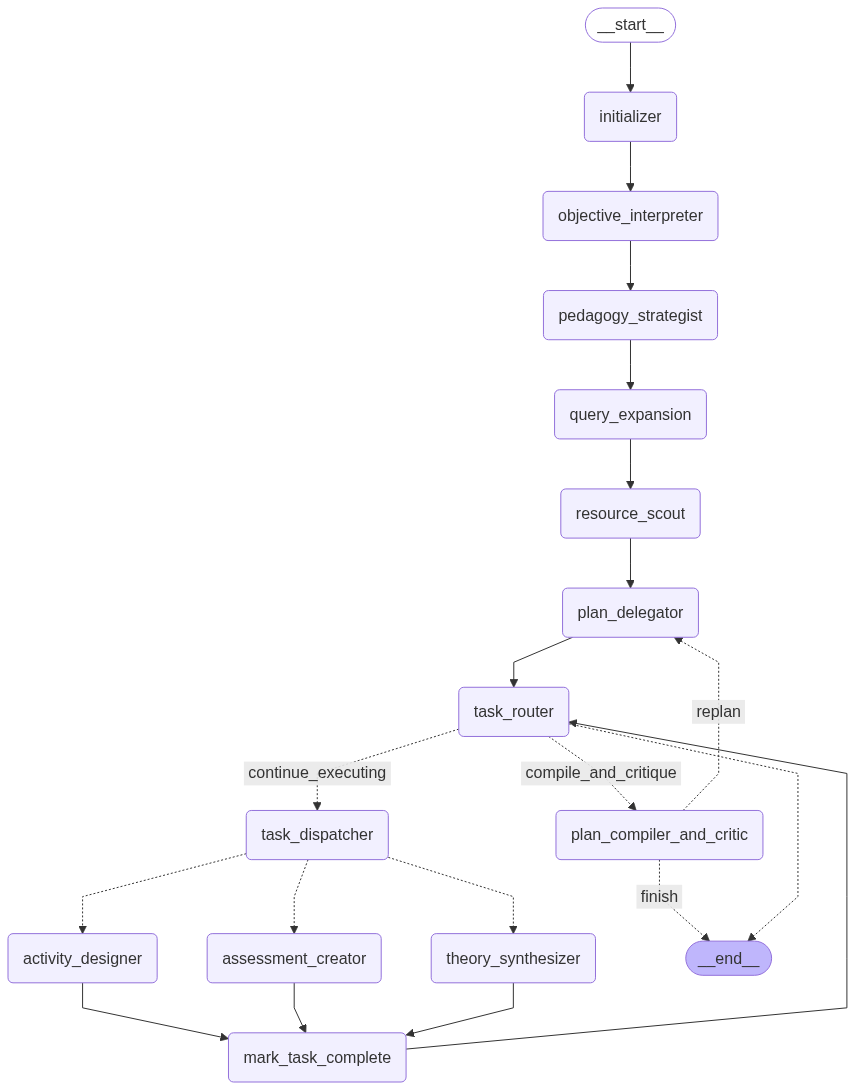

In [19]:
# ==============================================================================
# CELL 4 (Phiên bản 6.9 - Lắp ráp Graph, không đổi logic)
# ==============================================================================
from typing import Literal, Dict, Any

# --- CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI (ĐỊNH NGHĨA ĐẦY ĐỦ) ---

def mark_task_complete(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Node tiện ích: Đánh dấu nhiệm vụ hiện tại là 'completed' và xóa current_task_id
    để chuẩn bị cho vòng lặp tiếp theo của router.
    """
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: 
        return {}
    
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
            
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Node tiện ích: Kiểm tra xem còn nhiệm vụ nào trong danh sách ở trạng thái 'pending' không.
    """
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    # Tìm nhiệm vụ đầu tiên có trạng thái 'pending'
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}


async def task_dispatcher_agent(state: "TeacherStateV4") -> Dict[str, Any]:
    """
    Agent điều phối: Phân loại nhiệm vụ hiện tại và quyết định agent chuyên môn nào sẽ thực hiện.
    Sử dụng few-shot prompting để tăng độ chính xác.
    """
    print_step("`Agent: Task Dispatcher` (v6.9) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)

    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Nhiệm vụ:** Phân loại mô tả nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.

    **QUY TẮC PHÂN LOẠI:**
    - Nếu nhiệm vụ liên quan đến việc giảng giải, trình bày, giới thiệu, ôn tập lý thuyết, định nghĩa, định lý, khởi động, tổng kết -> **'theory_synthesizer'**.
    - Nếu nhiệm vụ yêu cầu học sinh thực hành, làm bài tập, luyện tập, thảo luận, làm việc nhóm, vận dụng kiến thức -> **'activity_designer'**.
    - Nếu nhiệm vụ là kiểm tra, đánh giá, cho bài tập về nhà, ra một bài toán khó để tổng kết, một bài toán chứng minh phức tạp -> **'assessment_creator'**.

    **VÍ DỤ:**
    1.  **Nhiệm vụ:** "Giáo viên ổn định lớp, kiểm tra bài cũ về các định nghĩa cơ bản của đường tròn"
        **Phân loại:** `theory_synthesizer` (vì là hoạt động mở đầu, ôn tập nhẹ nhàng)
    2.  **Nhiệm vụ:** "Học sinh làm các bài tập trong sách giáo khoa về tính độ dài cung tròn"
        **Phân loại:** `activity_designer` (vì là hoạt động luyện tập, thực hành)
    3.  **Nhiệm vụ:** "Học sinh vận dụng các kiến thức tổng hợp về góc nội tiếp và tứ giác nội tiếp để giải một bài toán chứng minh hình học phức tạp"
        **Phân loại:** `assessment_creator` (vì mang tính thử thách, đánh giá cao)
    4.  **Nhiệm vụ:** "Giáo viên tổng kết bài học và dặn dò bài tập về nhà"
        **Phân loại:** `theory_synthesizer` (vì là hoạt động kết thúc, mang tính thông báo)

    **NHIỆM VỤ CẦN PHÂN LOẠI:** "{task_description}"

    **YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`.
    """
    structured_llm = llm.with_structured_output(TaskClassification)

    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher khi phân loại: {e}. Giao nhiệm vụ cho agent mặc định 'activity_designer'.")
        next_agent = "activity_designer"

    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

# --- CÁC HÀM ĐIỀU HƯỚNG (ĐỊNH NGHĨA ĐẦY ĐỦ) ---
def route_after_router(state: "TeacherStateV4") -> Literal["continue_executing", "compile_and_critique"]:
    """Hàm điều kiện: Quyết định tiếp tục vòng lặp task hay chuyển sang bước tổng hợp."""
    if state.get("current_task_id") is None:
        return "compile_and_critique"
    else:
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV4") -> Literal["finish", "replan"]:
    """Hàm điều kiện: Quyết định kết thúc hay yêu cầu lập kế hoạch lại dựa trên phản hồi của Critic."""
    if state.get("reflection_notes"):
        print_step("ROUTER: Phát hiện phản hồi từ Critic. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER: Critic đã hài lòng. Kết thúc quy trình.")
        return "finish"


# --- XÂY DỰNG GRAPH PHIÊN BẢN 6.9 ---
workflow = StateGraph(TeacherStateV4)

# 1. Thêm tất cả các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("plan_compiler_and_critic", plan_compiler_and_critic_agent)

# 2. Kết nối các bước theo luồng logic
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "objective_interpreter")
workflow.add_edge("objective_interpreter", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# 3. Vòng lặp thực thi nhiệm vụ
workflow.add_conditional_edges(
    "task_router",
    route_after_router,
    {"continue_executing": "task_dispatcher", "compile_and_critique": "plan_compiler_and_critic"}
)
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {"activity_designer": "activity_designer", "assessment_creator": "assessment_creator", "theory_synthesizer": "theory_synthesizer"}
)
workflow.add_edge("activity_designer", "mark_task_complete")
workflow.add_edge("assessment_creator", "mark_task_complete")
workflow.add_edge("theory_synthesizer", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# 4. Vòng lặp tự sửa lỗi
workflow.add_conditional_edges(
    "plan_compiler_and_critic",
    route_after_compilation,
    {"replan": "plan_delegator", "finish": END}
)

# 5. Biên dịch Graph
app = workflow.compile()
print("✅ Graph 6.9 đã được biên dịch thành công.")

# 6. Vẽ biểu đồ để kiểm tra trực quan
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}")

In [20]:
# ==============================================================================
# CELL 5 (Phiên bản 6.9): CHẠY THỬ NGHIỆM
# ==============================================================================

async def run_graph_v6(user_request: str):
    # Kiểm tra các biến cần thiết
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V6.9 VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 100}
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V6.9.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_lesson_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v6.9)[/bold green]")
            console.print(Markdown(final_state_result["final_lesson_plan"]))
        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()


# Yêu cầu cũ để kiểm tra
request_v6_test = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9. Mục tiêu là các em có thể vận dụng được góc nội tiếp và cung bị chắn để giải các bài toán trong phần luyện tập. Buổi học sẽ diễn ra trong 2 tiết, tổng cộng 90 phút."

VERBOSE_MODE = True 

# Chạy quy trình đã được nâng cấp
await run_graph_v6(request_v6_test)

🚀 BẮT ĐẦU QUY TRÌNH V6.9 VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9. Mục tiêu là các em 
có thể vận dụng được góc nội tiếp và cung bị chắn để giải các bài toán trong phần luyện tập. Buổi học sẽ diễn ra 
trong 2 tiết, tổng cộng 90 phút.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Objective Interpreter` (v6.9) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 3,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': '9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Pedagogy Strategist` (v6.9) Bắt đầu...

✔️ Chiến lược sư phạm đã chọn:

{
│   'chosen_pedagogy': 'Phương pháp vấn đáp',
│   'pedagogy_rationale': 'Để đạt được mục tiêu soạn về đường tròn ngoại tiếp và đường tròn nội tiếp, phương pháp vấn đáp sẽ giúp học sinh lớp 9 phát triển kỹ năng tư duy phê phán và giải quyết vấn đề. Giáo viên sẽ đặt câu hỏi gợi mở, hướng dẫn học sinh thảo luận và tìm kiếm đáp án, từ đó giúp học sinh nắm vững kiến thức và phát triển kỹ năng ứng dụng.'
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Query Expansion` (v6.9) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và đường tròn nội tiếp lớp 9',
│   'tính chất đường tròn ngoại tiếp',
│   'đường tròn nội tiếp là gì',
│   'ứng dụng đường tròn ngoại tiếp trong thực tế',
│   'đường tròn ngoại tiếp và đường tròn nội tiếp khác nhau như thế nào',
│   'công thức tính đường tròn ngoại tiếp',
│   'đường tròn nội tiếp của tam giác',
│   'đường tròn ngoại tiếp của hình chữ nhật',
│   'tính đường tròn ngoại tiếp của hình thang',
│   'đường tròn nội tiếp và đường tròn ngoại tiếp trong hình học',
│   'đường tròn ngoại tiếp và đường tròn nội tiếp có gì giống nhau'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v6.9) đang tìm kiếm và sàng lọc...

> Tìm thấy 55 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất để xử lý.

> Đã sàng lọc và chọn ra các đoạn văn bản phù hợp nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa Toán 9 (từ RAG - đã sàng lọc)',
│   'summary': '**Tóm tắt kiến thức cốt lõi về đường tròn ngoại tiếp và đường tròn nội tiếp**\n\n**Định nghĩa:**\n\n* Đường tròn ngoại tiếp của một đa giác là đường tròn đi qua tất cả các đỉnh của đa giác đó.\n* Đường tròn nội tiếp của một đa giác là đường tròn nằm trong đa giác và tiếp xúc với tất cả các cạnh của đa giác đó.\n\n**Định lý:**\n\n* Nếu hai đường tròn ngoại tiếp nhau tại một điểm, thì tiếp tuyến của một đường tròn tại điểm đó sẽ tiếp xúc với đường tròn kia.\n* Nếu một đường tròn nội tiếp một tam giác, thì đường tròn đó sẽ đi qua trung điểm của mỗi cạnh của tam giác.\n\n**Ứng dụng:**\n\n* Trong một tam giác, đường tròn nội tiếp sẽ đi qua trung điểm của mỗi cạnh và sẽ là đường tròn ngoại tiếp của tam giác đó.\n* Nếu một đường tròn nội tiếp một tam giác, thì các cung nhỏ trên đường tròn đó sẽ bằng nhau.\n\n**Lưu ý:**\n\n* Khi chứng minh các vấn đề liên quan đến đường tròn ngoại tiếp và đường tròn nội tiếp, cần phải sử dụng các định lý và công thức lượng giác để giải quyết.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v6.9) đang lập kế hoạch chi tiết...

✔️ Đã tạo 7 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ổn định lớp và kiểm tra bài cũ',
│   │   'task_description': 'Giáo viên ổn định lớp, kiểm tra bài cũ về các kiến thức đã học trước đó',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Giới thiệu bài mới',
│   │   'task_description': 'Giáo viên giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp, nêu vấn đề và mục tiêu của bài học',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Giảng giải định nghĩa và định lý',
│   │   'task_description': 'Giáo viên giảng giải về định nghĩa và định lý của đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập củng cố lý thuyết',
│   │   'task_description': 'Học sinh luyện tập các bài tập củng cố lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Giảng giải ứng dụng',
│   │   'task_description': 'Giáo viên giảng giải về ứng dụng của đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Luyện tập vận dụng cao',
│   │   'task_description': 'Học sinh luyện tập các bài tập vận dụng cao về đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Tổng kết và dặn dò',
│   │   'task_description': 'Giáo viên tổng kết bài học, dặn dò học sinh về các nhiệm vụ cần hoàn thành',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ổn định lớp và kiểm tra bài cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Kiểm tra bài cũ',
│   'description': 'Giáo viên ổn định lớp, kiểm tra bài cũ về các kiến thức đã học trước đó',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên sẽ hỏi các câu hỏi để kiểm tra kiến thức của học sinh về các nội dung đã học trước đó.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giới thiệu bài mới' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Giáo viên giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp, nêu vấn đề và mục tiêu của bài học',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần nêu rõ vấn đề và mục tiêu của bài học, sau đó giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giảng giải định nghĩa và định lý' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 15 phút. Ghi đè bằng thời gian kế hoạch: 15 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giảng giải về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Giáo viên giảng giải về định nghĩa và định lý của đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'duration_minutes': 15,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên sẽ giải thích chi tiết về định nghĩa và định lý của đường tròn ngoại tiếp và đường tròn nội tiếp, sau đó sẽ cho học sinh thực hành vẽ đường tròn ngoại tiếp và đường tròn nội tiếp.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập củng cố lý thuyết' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...

> Thời gian LLM đề xuất: 10 phút. Ghi đè bằng thời gian kế hoạch: 10 phút.

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Luyện tập củng cố lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Học sinh luyện tập các bài tập củng cố lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'duration_minutes': 10,
│   'activity_type': 'Luyện tập củng cố lý thuyết',
│   'solution_guide': 'Hướng dẫn giải: Học sinh đọc lại lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp, sau đó làm các bài tập củng cố để nắm vững kiến thức.'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giảng giải ứng dụng' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 15 phút. Ghi đè bằng thời gian kế hoạch: 15 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giảng giải về ứng dụng của đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác',
│   'description': 'Giáo viên giảng giải về ứng dụng của đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác.',
│   'duration_minutes': 15,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên sẽ giải thích chi tiết về ứng dụng của đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác, sau đó sẽ cho học sinh thực hành các bài tập liên quan.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập vận dụng cao' (ID: 5)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...

> Thời gian LLM đề xuất: 20 phút. Ghi đè bằng thời gian kế hoạch: 20 phút.

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Vận dụng cao về đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác',
│   'description': 'Học sinh luyện tập các bài tập vận dụng cao về đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác.',
│   'duration_minutes': 20,
│   'activity_type': 'Luyện tập cặp đôi',
│   'solution_guide': 'Hướng dẫn giải: 1) Đọc kỹ đề bài và xác định các đường tròn ngoại tiếp và đường tròn nội tiếp trong tam giác. 2) Áp dụng các công thức và định lý đã học để giải quyết các bài tập. 3) Kiểm tra và đối chiếu kết quả với nhau.'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết và dặn dò' (ID: 6)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Tóm tắt bài học và dặn dò học sinh',
│   'description': 'Giáo viên tổng kết bài học, dặn dò học sinh về các nhiệm vụ cần hoàn thành',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần tóm tắt các nội dung chính của bài học, nhấn mạnh các điểm quan trọng và dặn dò học sinh về các nhiệm vụ cần hoàn thành.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v6.9) đang tổng hợp và đánh giá...

⚠️  CRITIC: Kế hoạch thất bại. Tổng thời gian thực tế (75 phút) nằm ngoài khoảng cho phép (yêu cầu khoảng 76 - 90 
phút). Hoặc số lượng hoạt động (7) quá ít. Hãy lập kế hoạch lại để đảm bảo thời gian và nội dung phù hợp.

> ROUTER: Phát hiện phản hồi từ Critic. Yêu cầu hệ thống lập kế hoạch lại.

------- Hoàn thành bước: plan_compiler_and_critic -------

> `Agent: Plan Delegator` (v6.9) đang lập kế hoạch chi tiết...

✔️ Đã tạo 8 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ổn định lớp và kiểm tra bài cũ',
│   │   'task_description': 'Giáo viên ổn định lớp, kiểm tra bài cũ về các kiến thức đã học trước đó',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Giới thiệu bài mới',
│   │   'task_description': 'Giáo viên giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp, nêu vấn đề và mục tiêu của bài học',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Giảng giải về đường tròn ngoại tiếp',
│   │   'task_description': 'Giáo viên giảng giải về định nghĩa và các tính chất của đường tròn ngoại tiếp',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập về đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh luyện tập các bài tập về đường tròn ngoại tiếp dưới sự hướng dẫn của giáo viên',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Giảng giải về đường tròn nội tiếp',
│   │   'task_description': 'Giáo viên giảng giải về định nghĩa và các tính chất của đường tròn nội tiếp',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Luyện tập về đường tròn nội tiếp',
│   │   'task_description': 'Học sinh luyện tập các bài tập về đường tròn nội tiếp dưới sự hướng dẫn của giáo viên',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Vận dụng về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'task_description': 'Học sinh vận dụng các kiến thức đã học để giải quyết các vấn đề liên quan đến đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Tổng kết và dặn dò',
│   │   'task_description': 'Giáo viên tổng kết bài học, dặn dò học sinh về các nhiệm vụ cần hoàn thành',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ổn định lớp và kiểm tra bài cũ' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Kiểm tra bài cũ',
│   'description': 'Giáo viên ổn định lớp, kiểm tra bài cũ về các kiến thức đã học trước đó',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên sẽ hỏi các câu hỏi để kiểm tra kiến thức của học sinh về các nội dung đã học trước đó.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giới thiệu bài mới' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Giáo viên giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp, nêu vấn đề và mục tiêu của bài học',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần nêu rõ định nghĩa, công thức và các ví dụ minh họa về đường tròn ngoại tiếp và đường tròn nội tiếp.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giảng giải về đường tròn ngoại tiếp' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 15 phút. Ghi đè bằng thời gian kế hoạch: 15 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giảng giải về định nghĩa và các tính chất của đường tròn ngoại tiếp',
│   'description': 'Giáo viên giảng giải về định nghĩa và các tính chất của đường tròn ngoại tiếp, học sinh lắng nghe và ghi chép lại các nội dung quan trọng.',
│   'duration_minutes': 15,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần chuẩn bị các ví dụ minh họa và các câu hỏi gợi mở để học sinh tham gia thảo luận.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập về đường tròn ngoại tiếp' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...

> Thời gian LLM đề xuất: 10 phút. Ghi đè bằng thời gian kế hoạch: 10 phút.

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Luyện tập đường tròn ngoại tiếp',
│   'description': 'Học sinh luyện tập các bài tập về đường tròn ngoại tiếp dưới sự hướng dẫn của giáo viên.',
│   'duration_minutes': 10,
│   'activity_type': 'Luyện tập cấp độ',
│   'solution_guide': 'Giáo viên hướng dẫn học sinh thực hiện các bước sau: 1) Nhận dạng đường tròn ngoại tiếp, 2) Xác định tâm và bán kính, 3) Áp dụng công thức tính chu vi và diện tích.'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Giảng giải về đường tròn nội tiếp' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 15 phút. Ghi đè bằng thời gian kế hoạch: 15 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Giảng giải về định nghĩa và các tính chất của đường tròn nội tiếp',
│   'description': 'Giáo viên giảng giải về định nghĩa và các tính chất của đường tròn nội tiếp, học sinh lắng nghe và ghi chép lại.',
│   'duration_minutes': 15,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần giải thích rõ ràng và chi tiết về định nghĩa và các tính chất của đường tròn nội tiếp, học sinh cần lắng nghe và ghi chép lại đầy đủ.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập về đường tròn nội tiếp' (ID: 5)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...

> Thời gian LLM đề xuất: 10 phút. Ghi đè bằng thời gian kế hoạch: 10 phút.

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Luyện tập đường tròn nội tiếp',
│   'description': 'Học sinh luyện tập các bài tập về đường tròn nội tiếp dưới sự hướng dẫn của giáo viên.',
│   'duration_minutes': 10,
│   'activity_type': 'Luyện tập cấp độ',
│   'solution_guide': 'Giáo viên hướng dẫn học sinh thực hiện các bước sau: 1) Nhận dạng đường tròn nội tiếp, 2) Xác định tâm và bán kính, 3) Áp dụng công thức tính diện tích và chu vi.'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng về đường tròn ngoại tiếp và đường tròn nội tiếp' (ID: 6)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v6.9) đang thiết kế hoạt động vận dụng...

> Thời gian LLM đề xuất: 20 phút. Ghi đè bằng thời gian kế hoạch: 20 phút.

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Áp dụng đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Học sinh sẽ áp dụng các kiến thức đã học để giải quyết các vấn đề liên quan đến đường tròn ngoại tiếp và đường tròn nội tiếp.',
│   'duration_minutes': 20,
│   'activity_type': 'Luyện tập cấp độ',
│   'solution_guide': 'Hướng dẫn học sinh vẽ đường tròn ngoại tiếp và đường tròn nội tiếp của một đa giác, sau đó áp dụng các công thức đã học để giải quyết các vấn đề.'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết và dặn dò' (ID: 7)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v6.9) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v6.9) đang thiết kế hoạt động lý thuyết...

> Thời gian LLM đề xuất: 5 phút. Ghi đè bằng thời gian kế hoạch: 5 phút.

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Tóm tắt bài học và dặn dò học sinh',
│   'description': 'Giáo viên tổng kết bài học, dặn dò học sinh về các nhiệm vụ cần hoàn thành',
│   'duration_minutes': 5,
│   'activity_type': 'Giảng giải lý thuyết',
│   'solution_guide': 'Giáo viên cần tổng kết lại các nội dung chính của bài học, nhắc lại các nhiệm vụ cần hoàn thành và dặn dò học sinh về các công việc cần làm trong thời gian tới.'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v6.9) đang tổng hợp và đánh giá...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...

> ROUTER: Critic đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: plan_compiler_and_critic -------

🏁 KẾT THÚC QUY TRÌNH V6.9.

📝 GIÁO ÁN HOÀN CHỈNH (v6.9)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          GIÁO ÁN BÀI DẠY: Đường tròn ngoại tiếp và đường tròn nội tiếp                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                I. THÔNG TIN CHUNG                                                 

 • Môn học: Toán                                                                                                   
 • Lớp: 9                                                                                                          
 • Thời lượng dự kiến: 85 phút / 90 phút                                                                           
 • Phương pháp sư phạm chủ đạo: Phương pháp vấn đáp                                                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Đường tròn ngoại tiếp và đường tròn nội tiếp để giải quyết các bài toán liên  
   quan.                                                                                                           
 • Rèn luyện kỹ năng tư duy logic, mô hình hóa toán học và giải quyết vấn đề.                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                   III. CHUẨN BỊ                                                   

 • Giáo viên: Bảng phụ, phấn màu, phiếu học tập (nếu có).                                                          
 • Học sinh: Sách giáo khoa, vở ghi, dụng cụ học tập (compa, thước kẻ).                                            
 • Nguồn tài liệu tham khảo: Sách giáo khoa Toán 9 (từ RAG - đã sàng lọc)                                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                                       Hoạt động 1: Kiểm tra bài cũ (5 phút)                                       

 • Loại hình: Giảng giải lý thuyết                                                                                 
 • Mô tả/Nhiệm vụ: Giáo viên ổn định lớp, kiểm tra bài cũ về các kiến thức đã học trước đó                         
 • Gợi ý đáp án/Hướng dẫn giải: Giáo viên sẽ hỏi các câu hỏi để kiểm tra kiến thức của học sinh về các nội dung đã 
   học trước đó.                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Hoạt động 2: Giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp (5 phút)                  

 • Loại hình: Giảng giải lý thuyết                                                                                 
 • Mô tả/Nhiệm vụ: Giáo viên giới thiệu về đường tròn ngoại tiếp và đường tròn nội tiếp, nêu vấn đề và mục tiêu của
   bài học                                                                                                         
 • Gợi ý đáp án/Hướng dẫn giải: Giáo viên cần nêu rõ định nghĩa, công thức và các ví dụ minh họa về đường tròn     
   ngoại tiếp và đường tròn nội tiếp.                                                                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            Hoạt động 3: Giảng giải về đ